%%HTML
<table style="width:100%">
    <tr>
    <td style="text-align:right"><a target="_blanc" href="http://www.irt-saintexupery.com/"></a><img src="http://www.irt-saintexupery.com/wp-content/uploads/2015/05/logo.jpg"> </td>
    <td style="text-align:left"><a target="_blanc" href="http://www.irt-saintexupery.com/"></a><img src="http://www.enseeiht.fr/skins/enseeiht-new/resources/img/logo-enseeiht.png"> </td>
     </tr>
</table>
<center><h1>Devloppement du robot TwIRTee</h1></center>
<p text-align="right">
<table>
    <tr>
    <td>Tuteur :<br>Auteur :</td>
    <td style="text-align:right">Eric JENN<br>Sami EZZEROUALI</td>
    </tr>
</table>
</p>


## Simulation du modèle de positionnement par trilatération

In [5]:
import matplotlib.pyplot as plt
from numpy import *
from math import pi
from random import *




rate=0.01 #random function to mesured cercles rayons 
max=10 # x,y parametre "t" in robotMove 
npoints=20 # robot's number of steps




- La fonction anchorsPosition trace l'emplacement des beacons dans le cas de 4 émetteurs en positionnement carré [0,0] [0,1] [1,1] et [1,0]
##### TODO:	Rendre la fonction adaptable en nombre d'emetteurs, en suivant les methodes de placement évoqué dans "Roa et al. - 2007 - Optimal placement of sensors for trilateration Re"


In [6]:
def anchorsPosition(delta):
	_Xaux=[0,0,delta,delta]
	_Yaux=[0,delta,delta,0]
	_position=[_Xaux,_Yaux]
	return _position;

vector=anchorsPosition(5000)

In [7]:
def drawCercles(vector,_R):
	teta=linspace(0,2*pi,720);
	cercles=[0,0]
	cx=[]
	cy=[]
	for k in range(len(vector[0])):
		for i in range(len(teta)):
			cx.append(vector[0][k]+_R[k]*sin(teta[i]))
			cy.append(vector[1][k]+_R[k]*cos(teta[i]))
	cercles=[cx,cy]
	return cercles

In [8]:

def robotMove(max,npoints):
    t=linspace(0,max,npoints)
    #x=150*sin(t)+60*t+200
    #y=100*t
    x=-500+250*t
    y=500+800*sin(t)
    robot=[]
    robot.append(x)
    robot.append(y)
    return robot

In [9]:
def rightRayons(position,vector):
    ray=[]
    for i in range(len(vector[1])):
        xyanchor=array((0,0))
        xyanchor[0]=vector[0][i]
        xyanchor[1]=vector[1][i]
        ray.append(linalg.norm(xyanchor-position))
    return ray

In [10]:
def distanceSensors(rate,ray):
	dvector=[]
	for i in range(len(ray)):
		dvector.append(ray[i]+randint(-int(ray[i]*rate)-1,int(ray[i]*rate+1)))
	return dvector;

In [11]:
vector=anchorsPosition(1000)
robot=robotMove(max,npoints)


* 1er cas de figure :mesures parfaites

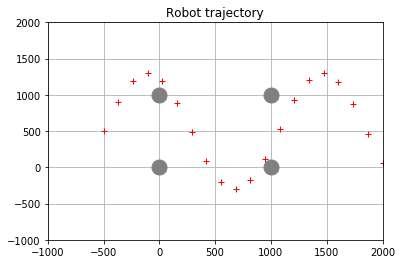

In [12]:

plt.figure(1)
plt.title("Robot trajectory")
plt.plot(vector[0],vector[1],"o",markersize=15,color="gray")
plt.plot(robot[0],robot[1],"+",color="red")
plt.grid(True)
plt.ylim(-1000,2000)
plt.xlim(-1000,2000)
plt.show()

# Case 0 : 100% accurate data from DecaWave sensors 
* in this case, cercles intersect in one and only one point, then the position is unique

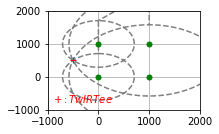

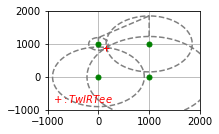

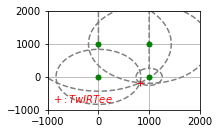

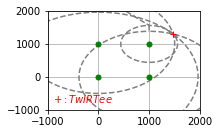

In [13]:

plt.figure(2)
plt.title("Cas parfait de la méthode de trilatération")
i=221
for j in range(4):
    plt.subplot(i+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])
    ray=rightRayons(position,vector)
    cercles = drawCercles(vector,ray)
    plt.plot(cercles[0],cercles[1],"--",color="gray")
    plt.text(-900,-800, r'$ +: TwIRTee $',color='red')
    plt.plot(vector[0],vector[1],"o",markersize=5,color="green")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()

## Case 1 : we add some noise to distances

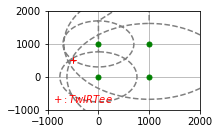

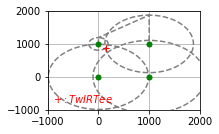

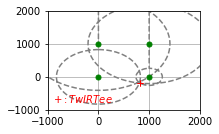

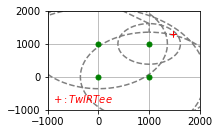

In [14]:

plt.figure(3)
plt.title("Reel life example")
i=221
for j in range(4):
    plt.subplot(i+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])
    ray=rightRayons(position,vector)
    mesuredRay=distanceSensors(0.1,ray)
    cercles = drawCercles(vector,mesuredRay)
    plt.plot(cercles[0],cercles[1],"--",color="gray")
    plt.text(-900,-800, r'$ +: TwIRTee $',color='red')
    plt.plot(vector[0],vector[1],"o",markersize=5,color="green")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()
    

circles do not intersect in one point 
# To Solve this issue, we will try the optimisation methods below :
#### 1- leastsquare using QR decomposition :
### leastSquareQR : it must compute the X,Y cordinate according to A and b matrix using QR decomposition method


In [15]:
def leastSquareQR(A,b):
    q,r=linalg.qr(A)
    rinv=linalg.inv(r)
    qtrns=transpose(q)
    x1=matmul(rinv,qtrns)
    x=matmul(x1,b)
    return x


### ComputeXY() : this function must compute the (x,y) coordinates of the robot's coordinates according to Ray[] and anchorsVector
* For now, I use leastSquareQR() to solve the problem, after studying several methods of optimisation, I may change this one


In [16]:
def computeXY(ray,anchorsVector):
    #print(ray)
    position=[0,0]
    _x=anchorsVector[0]
    _y=anchorsVector[1]
    A=[]
    for i in range(1,len(_x)):
        A.append([_x[i]-_x[0],_y[i]-_y[0]])
    b=[]
    for i in range(1,len(ray)):
        b.append(0.5*(ray[0]**2-ray[i]**2+(_x[i]-_x[0])**2+(_y[i]-_y[0])**2))
    position=leastSquareQR(A,b)
    return position

#x=computeXY(mesuredRay,vector)
#x[0]

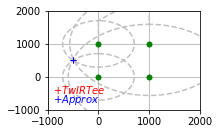

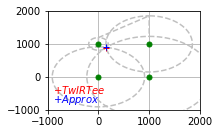

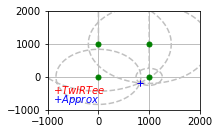

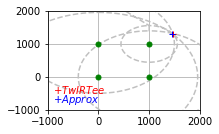

In [17]:


plt.figure(3)

for j in range(4):
    plt.subplot(221+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])

    ray=rightRayons(position,vector);
    mesuredRay=distanceSensors(rate,ray);
    aprox=computeXY(mesuredRay,vector);
    cercles = drawCercles(vector,mesuredRay);    
    
    plt.plot(cercles[0],cercles[1],"--",color="silver")
    plt.plot(vector[0],vector[1],"o",markersize=5,color="Green")
    plt.text(-900,-500, r'$ + TwIRTee $',color="red")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.text(-900,-800, r'$ + Approx $',color="blue")
    plt.plot(aprox[0],aprox[1],"+",color="blue")
    
    #print(aprox)
    
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()

* We see that points have almost the same coordinates, let's see how accurate is this method 

## error() function must calculate the distance between the position and it's approximation
### it return an error vector made like this :
* error[0] : absis axe
* error[1] : error in x
* error[2] : error in y
* error[3] : error in distance
* error[4] : percentage of error on the distance



In [18]:

def error(robot,vector):
    error=[[],[],[],[],[]]
    
    for j in range(len(robot[0])):
        
        position=[]
        position.append(robot[0][j])
        position.append(robot[1][j])
        ray=rightRayons(position,vector)
        mesuredRay=distanceSensors(rate,ray)
        approx=computeXY(mesuredRay,vector)
        
        error[0]=linspace(0,len(robot[0]),len(robot[0]))
        error[1].append(abs(robot[0][j]-approx[0]))
        error[2].append(abs(robot[1][j]-approx[1]))
        error[3].append(sqrt((robot[0][j]-approx[0])**2 + (robot[1][j]-approx[1])**2))
        error[4].append(100*error[3][j]/(sqrt((robot[0][j])**2 + (robot[1][j])**2)))
        
    
    return error

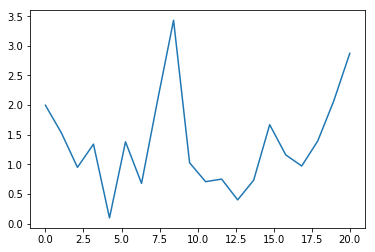

In [19]:
x=error(robot,vector)
plt.figure(4)
#plt.plot(x[0],x[1])
#plt.plot(x[0],x[2])
plt.plot(x[0],x[4],)

plt.show()
